In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


In [19]:
#Importing csv file data.csv and storing the data in 'df' 
df = pd.read_csv('data/housepricedata.csv', header = None) 
df.head() #Displaying the table


,0,1,2,3,4,5,6,7
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


In [20]:
# Adding column names to df
columns = ['serial', 'date', 'age', 'distance', 'stores', 'latitude', 'longitude', 'price']
df.columns = columns
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


# Preparing Data

In [21]:
# Check for null values in df 
df.isnull().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

In [22]:
# Drop serial column as it is not needed
df = df.iloc[:,1:] 
df.head()

,date,age,distance,stores,latitude,longitude,price
0,2009,21,9,6,84,121,14264
1,2007,4,2,3,86,121,12032
2,2016,18,3,7,90,120,13560
3,2002,13,2,2,80,128,12029
4,2014,25,5,8,81,122,14157


In [23]:
# Data normalization
df_normal = (df - df.mean()) / df.std()
df_normal.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


In [24]:
# Method to convert label value back to original value
# label valuues are normalized values thus we'll get predicted values in normalized form
# and we need to convert them back to original values for interpretation
import numpy as np

y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    # If pred is an array, take the first (and presumably only) element
    if isinstance(pred, (np.ndarray, list)) and len(pred) == 1:
        pred = pred[0]
    return int(pred * y_std + y_mean)

In [25]:
# Remove price column from df_normal for training and use it as label
X = df_normal.iloc[:, df_normal.columns != 'price']
X.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


In [26]:
Y = df_normal.iloc[:, df_normal.columns == 'price']
Y.head()

,price
0,0.350088
1,-1.836486
2,-0.339584
3,-1.839425
4,0.245266


In [27]:
X_values = X.values
Y_values = Y.values
print("X shape: ", X_values.shape)
print("Y shape: ", Y_values.shape)

X shape:  (5000, 6)
Y shape:  (5000, 1)


In [28]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_values, Y_values, test_size=0.05, shuffle=True, random_state=0)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750, 1)
X_test shape:  (250, 6)
y_test shape:  (250, 1)


In [29]:
import tensorflow.keras.backend as K

def r_squared_error(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))  # Residual sum of squares
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Total sum of squares
    return 1 - ss_res / (ss_tot + K.epsilon())  # Add epsilon to avoid division by zero

# Creating 2 Models for training. Will compare Early Stopping and Dropout

In [44]:
# Working with numerical data - defining a NN model with no activation function => essentially a linear regression model
# Since regression problem relu activation function is used 
model = Sequential([
    Input(shape=(6,)),
    Dense(10, activation='relu'),                    # Input Layer                                
    Dense(20, activation='relu'),                    # Hidden Layer
    Dense(5, activation='relu'),                     # Hidden Layer
    Dense(1)                                         # Output layer for regression (no activation, or linear)
])
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[r_squared_error, 'mean_absolute_error'])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 10)             │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 5)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401 (1.57 KB)

 Trainable params: 401 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test) ,epochs=100, callbacks=[early_stopping])

Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6259 - mean_absolute_error: 0.6235 - r_squared_error: 0.3295 - val_loss: 0.2152 - val_mean_absolute_error: 0.3737 - val_r_squared_error: 0.7408
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2014 - mean_absolute_error: 0.3734 - r_squared_error: 0.7766 - val_loss: 0.1716 - val_mean_absolute_error: 0.3452 - val_r_squared_error: 0.7913
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1713 - mean_absolute_error: 0.3511 - r_squared_error: 0.8136 - val_loss: 0.1682 - val_mean_absolute_error: 0.3437 - val_r_squared_error: 0.7940
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1620 - mean_absolute_error: 0.3418 - r_squared_error: 0.8250 - val_loss: 0.1608 - val_mean_absolute_error: 0.3395 - val_r_squared_error: 0.8037
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1626 - mean_absolute_error: 0.3459 - r_squared_error: 0.8192 - val_loss: 0.1534 - val_mean_absolute_error: 0.

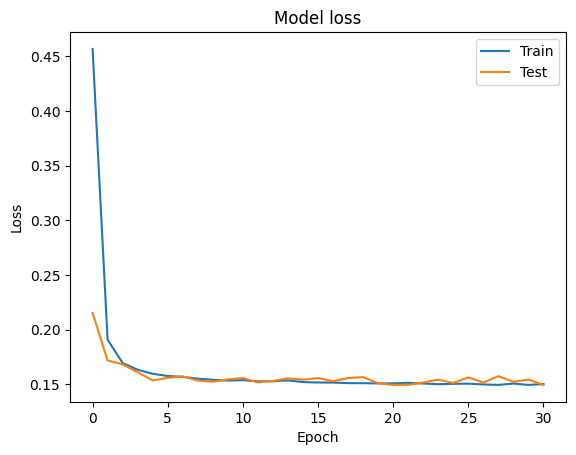

In [46]:
#plot training and validation loss 

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc = 'upper right')
plt.show()

In [47]:
# Define a new model but with dropout layers to prevent overfitting
model_drop = Sequential([
    Dense(10, input_shape=(6,), activation='relu'),  # Input Layer
    Dropout(0.2),                                    # Dropout after first layer
    Dense(20, activation='relu'),                    # Hidden Layer
    Dropout(0.2),                                    # Dropout after second layer
    Dense(5, activation='relu'),                     # Hidden Layer
    Dropout(0.2),                                    # Dropout after third layer
    Dense(1)                                         # Output Layer
])
# Compile the model
model_drop.compile(optimizer='adam', loss='mean_squared_error', metrics=[r_squared_error, 'mean_absolute_error'])

# Train the model with dropout
history_drop = model_drop.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)
model_drop.summary()


Epoch 1/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9677 - mean_absolute_error: 0.7950 - r_squared_error: 0.0254 - val_loss: 0.5444 - val_mean_absolute_error: 0.5983 - val_r_squared_error: 0.3491
Epoch 2/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7370 - mean_absolute_error: 0.6918 - r_squared_error: 0.2466 - val_loss: 0.3700 - val_mean_absolute_error: 0.4830 - val_r_squared_error: 0.5587
Epoch 3/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6216 - mean_absolute_error: 0.6250 - r_squared_error: 0.3700 - val_loss: 0.2609 - val_mean_absolute_error: 0.4113 - val_r_squared_error: 0.6874
Epoch 4/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5088 - mean_absolute_error: 0.5714 - r_squared_error: 0.4722 - val_loss: 0.1962 - val_mean_absolute_error: 0.3627 - val_r_squared_error: 0.7632
Epoch 5/100
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4374 - mean_absolute_error: 0.5184 - r_squared_error: 0.5331 - val_loss: 0.1753 - val_mean_absolute_error: 0.

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 10)             │            70 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 5)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,205 (4.71 KB)

 Trainable params: 401 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 804 (3.14 KB)

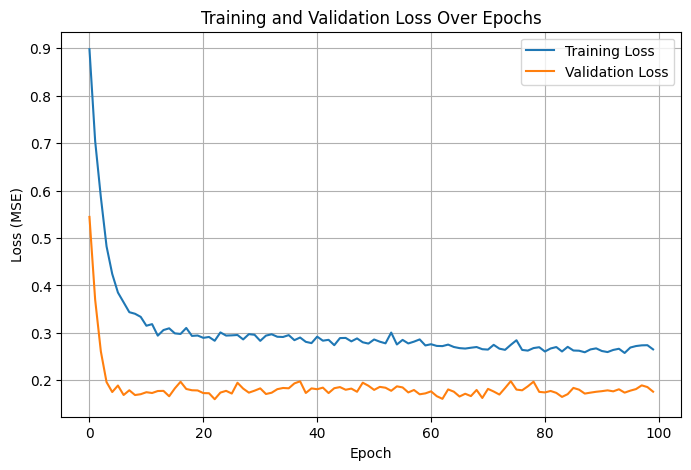

In [48]:

# Extract loss and val_loss from history
loss = history_drop.history['loss']
val_loss = history_drop.history['val_loss']

# Plotting
plt.figure(figsize=(8,5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

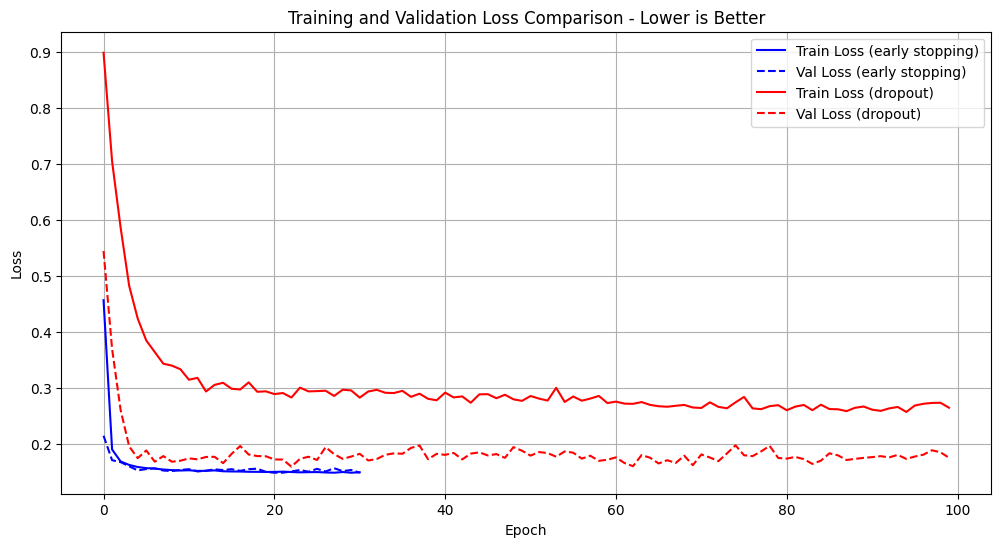

In [49]:
plt.figure(figsize=(12, 6))

# Original model loss
plt.plot(history.history['loss'], 'b-', label='Train Loss (early stopping)')
plt.plot(history.history['val_loss'], 'b--', label='Val Loss (early stopping)')

# Dropout model loss
plt.plot(history_drop.history['loss'], 'r-', label='Train Loss (dropout)')
plt.plot(history_drop.history['val_loss'], 'r--', label='Val Loss (dropout)')

plt.title('Training and Validation Loss Comparison - Lower is Better')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Analyzing performance

In [50]:
predictions = model.predict(X_test)
price_on_trained_data =  [convert_label_value(y) for y in predictions]

pred_dropout = model_drop.predict(X_test)
price_on_trained_data_drop = [convert_label_value(y) for y in pred_dropout]

# Convert y_test to original price values
price_on_y_test = [convert_label_value(y) for y in y_test]

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [51]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

mae_early = mean_absolute_error(price_on_y_test, price_on_trained_data)
mae_dropout = mean_absolute_error(price_on_y_test, price_on_trained_data_drop)

mse_early = mean_squared_error(price_on_y_test, price_on_trained_data)
mse_dropout = mean_squared_error(price_on_y_test, price_on_trained_data_drop)

r2_early = r2_score(price_on_y_test, price_on_trained_data)
r2_dropout = r2_score(price_on_y_test, price_on_trained_data_drop)

print(f"MAE (Early Stopping): {mae_early:.2f}")
print(f"MAE (Dropout): {mae_dropout:.2f}")
print("")
print(f"MSE (Early Stopping): {mse_early:.2f}")
print(f"MSE (Dropout): {mse_dropout:.2f}")
print("")

print("R² - closer to 1 is better")
print(f"R² (Early Stopping): {r2_early:.3f}")
print(f"R² (Dropout): {r2_dropout:.3f}")


MAE (Early Stopping): 335.72
MAE (Dropout): 350.46

MSE (Early Stopping): 155628.58
MSE (Dropout): 183436.52

R² - closer to 1 is better
R² (Early Stopping): 0.827
R² (Dropout): 0.796


In [52]:
final_gap_early = history.history['val_loss'][-1] - history.history['loss'][-1]
final_gap_drop = history_drop.history['val_loss'][-1] - history_drop.history['loss'][-1]

print("A larger gap = higher chance of overfitting")
print(f"Train/Val Loss Gap (Early Stopping): {final_gap_early:.4f}")
print(f"Train/Val Loss Gap (Dropout):  {final_gap_drop:.4f}")

A larger gap = higher chance of overfitting
Train/Val Loss Gap (Early Stopping): -0.0007
Train/Val Loss Gap (Dropout):  -0.0891


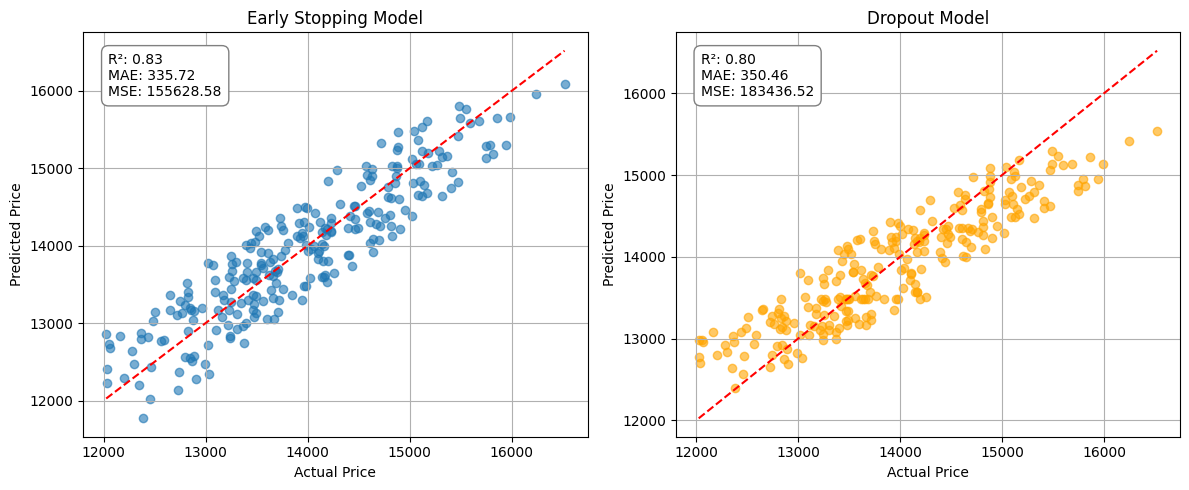

In [53]:


plt.figure(figsize=(12, 5))

# Early Stopping model
plt.subplot(1, 2, 1)
plt.scatter(price_on_y_test, price_on_trained_data, alpha=0.6)
plt.plot([min(price_on_y_test), max(price_on_y_test)], 
         [min(price_on_y_test), max(price_on_y_test)], 'r--')
plt.title('Early Stopping Model')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)

# Add text for metrics
plt.text(0.05, 0.95, f'R²: {r2_early:.2f}\nMAE: {mae_early:.2f}\nMSE: {mse_early:.2f}', 
         transform=plt.gca().transAxes, 
         fontsize=10, 
         verticalalignment='top', 
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))

# Dropout model
plt.subplot(1, 2, 2)
plt.scatter(price_on_y_test, price_on_trained_data_drop, alpha=0.6, color='orange')
plt.plot([min(price_on_y_test), max(price_on_y_test)], 
         [min(price_on_y_test), max(price_on_y_test)], 'r--')
plt.title('Dropout Model')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)

# Add text for metrics
plt.text(0.05, 0.95, f'R²: {r2_dropout:.2f}\nMAE: {mae_dropout:.2f}\nMSE: {mse_dropout:.2f}', 
         transform=plt.gca().transAxes, 
         fontsize=10, 
         verticalalignment='top', 
         bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()
